# Step 1. Set working directory and import OMEGA

In [1]:
cd /Users/jz-rolling/Desktop/OMEGA/

/Users/jz-rolling/Desktop/OMEGA


In [2]:
"""
Import other necessary packages. 
"""

import OMEGA_core as om
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit 

# Step 2. analysis of single input file using OMEGA

## standard input

In [3]:
# 0. Put a timer on. The processing time increases when a crowded or super large image is provided. 
# On my computer (MBP 16-inch, 2019), it takes about 20-30 seconds to fully process 
# a 2048X2048 image with 300-800 cells. 
t1 = timeit.default_timer()

# 1. Activate an OMEGA.Image object
data_folder = '/Users/jz-rolling/Desktop/OMEGA/demo/'
img = om.Image()

# 2. Load image file, specify the channel to be used for segmentation when a hyperstack image is provided.
# For instance, if the .nd2 file has two channels, phase contrast and FITC, which are stacked accordingly,
# then the index for phase contrast channel will be 0, and the index for FITC channel will be 1 (or -1 with Python)

# 2-1. Load .nd2 image data
#img.read_nd2_file(data_folder + 'mild_clumping.nd2', mask_channel_id=-1)

# 2-2. Or .tiff file:
img.read_tiff_file(data_folder + 'test_img_1_clip.tif', mask_channel_id=-1)

# 3. Import configurations
config_file = '/Users/jz-rolling/Desktop/OMEGA/OMEGA_core/configurations/configuration_msm.ini'
img.config = om.config.Preset_configurations_default(config_file).config

# 4. Background subtraction and signal enhancement
img.crop_edge(offset_correction=True) #optional, trims off edge pixels and calibrates xy drifts among different channels
img.enhance_brightfield()
img.enhance_fluorescence() 

# 5. Split clusters.
# 5-1. load the pretrained mini-neural-network classifier and metrics normalizer 
# if you want to use the default classifer and normalizer, set the two to 'default'
boundary_classifier='./OMEGA_core/configurations/boundary_MLP.pk'
boundary_normalizer='./OMEGA_core/configurations/normalizer.pk'
# boundary_classifier='default'
# boundary_normalizer='default'

# 5-2. Find the clusters!
img.locate_clusters()

# 5-3. Split clusters into minions. 
img.cluster_segmentation(predictor=boundary_classifier,
                         normalizer=boundary_normalizer)

# 6. Final step, extract single cells.
# The split_branches attribute determines whether or not to perform an exhaustive segmentation.
# This step will produce more segmented single cells for analysis, however, the segmentation quality
# might be slightly lower. Recommended when the overall image quality is high and high coverage rate
# is important. 

img.cell_segmentation(split_branches=True,filter_by_shapeindex_quality=True)
t2 = timeit.default_timer()
print("{} seconds used, not too bad!".format(round(t2-t1,2)))

5.09 seconds used, not too bad!


# Step 3. Plot

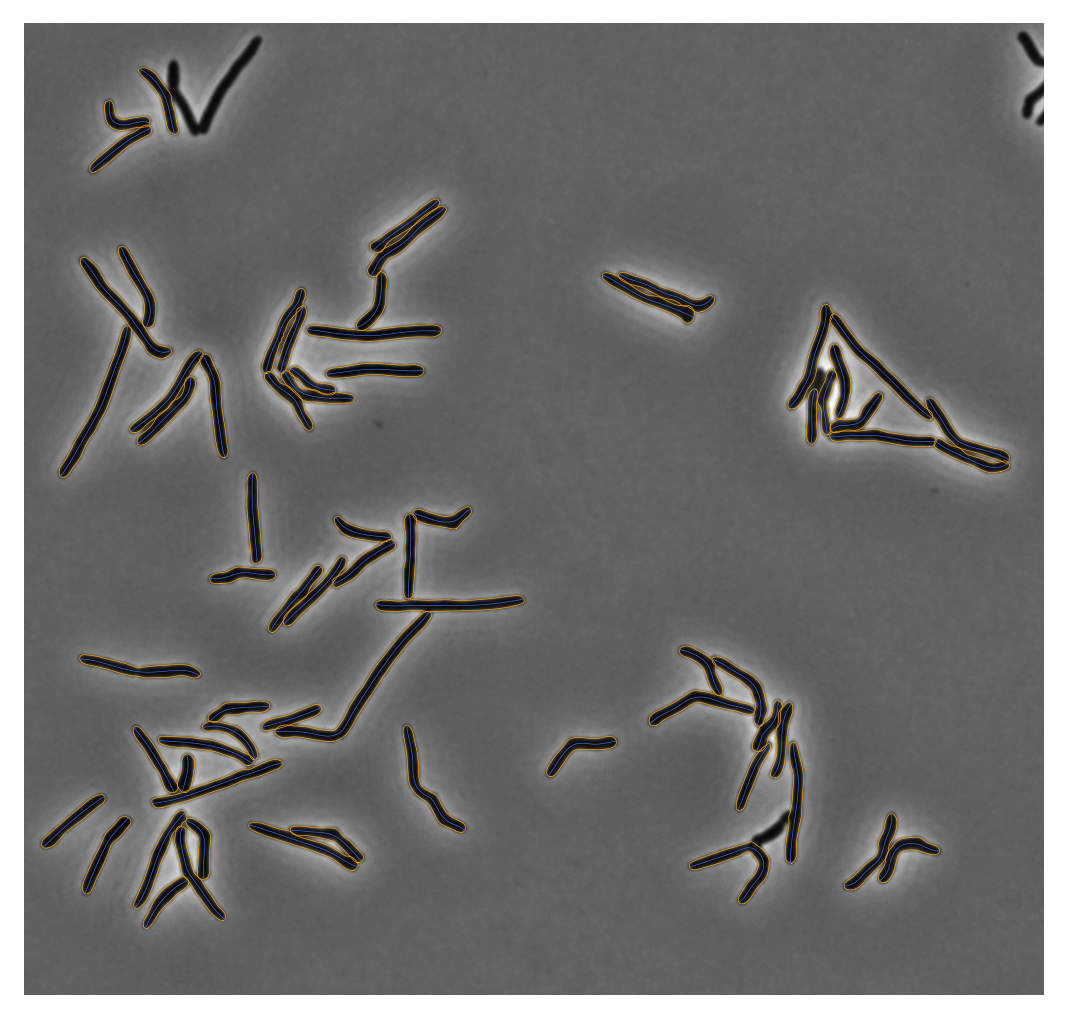

In [4]:
# Plot segmented image, call the OMEGA.plot function
# Successfully extracted single cells are enclosed in yellow contours
# Undetermined particles are colored red
om.plot.plot_segmented_image(img,lw=0.2)

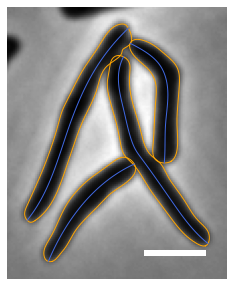

In [5]:
# Zoom-in at one of the clusters with OMEGA.plot.plot_segmented_cluster function
# To save the plot, simply assign True to the savefig attribute and specify the output filename

"""
# save plot
filename = 'path/to/save/filename.png'
om.plot.plot_segmented_cluster(image=img, cluster_key=31, savefig=True, filename=filename,
                               scale_bar=True, scale_bar_length=2)
"""
cluster_key = 25
om.plot.plot_segmented_cluster(image=img, cluster_key=cluster_key, scale_bar=True, scale_bar_length=2)

Here're keys to all the cluster:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]

Here're keys to all the cells in cluster 31:
 [3, 4, 5, 6]


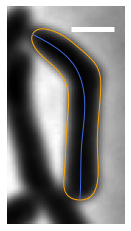

In [6]:
# How about cells? The OMEGA package has a hierachical data structure and requires a set of keys to
# get to a single cell

cluster_keys = img.clusters.keys()
print("Here're keys to all the cluster:\n", list(cluster_keys))

# will take cluster 31 as an example:
cell_keys = img.clusters[15].cells.keys()
print("\nHere're keys to all the cells in cluster 31:\n", list(cell_keys))

# now get cell No.2 of cluster No.31
cell = img.clusters[25].cells[2]

# Plot, one can apply the same 'saveimg' trick to save the plot
om.plot.plot_cell(cell, dpi=50, scale_bar=True, 
                  scale_bar_weight=5, lw=1)

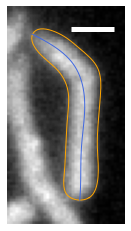

In [7]:
# Plot fluorescent image
om.plot.plot_cell(cell, dpi=50, scale_bar=True, channel='C1',
                  scale_bar_weight=5, lw=1)

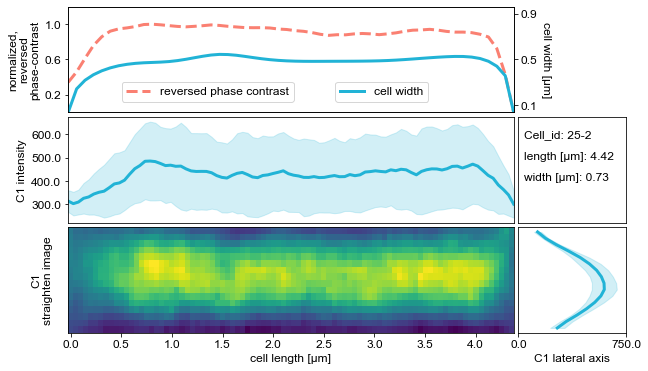

In [8]:
# We could also plot out the basic signal profiles of single cells
om.plot.cell_plot_full(cell)

# Step 4. Get cellular statistics

In [9]:
# An easier way to retrieve all cells from an Image object is to call the .get_cells function, for example:

cells = img.get_cells(discarded=True)
print("{} cells found!".format(len(cells)))

69 cells found!


In [10]:
# with all the cells in hand, data retrieval is straight forward. 
# OMEGA.io._to_dataframe converts all cellular data into several Pandas dataframes.

data_dict = om.io._to_dataframe(cells)

print('Use one of the following keys to attain dataframe:')
print(list(data_dict.keys()))

# Use 'morphology' as an example to examine the shape properties of M. smegmatis cells:
morph_df = data_dict['morphology']
morph_df.head()

Use one of the following keys to attain dataframe:
['Shape_index', 'C1', 'C2', 'morphology']


,image_label,cluster_label,cell_label,eccentricity,solidity,circularity,convexity,average_bending_energy,min_curvature,max_curvature,...,std_curvature,rough_Length,rough_sinuosity,branch_count,length,sinuosity,width_median,width_std,width_max,width_minwidth_symmetry
0,None,2,2,0.984601,0.667867,0.294,0.989,0.000097,0.931319,1.326277,...,0.086197,5.749068,1.000000,0,5.059337,1.041,0.671133,0.043144,0.718317,None
1,None,4,2,0.898706,0.653631,0.384,0.927,0.000073,0.824285,1.337673,...,0.094879,4.412346,1.230071,0,3.857278,1.286,0.683858,0.047685,0.743650,None
2,None,4,3,0.989670,0.816027,0.322,0.997,0.000067,0.977886,1.277998,...,0.085650,5.463233,1.000000,0,4.839516,1.005,0.664074,0.030978,0.687501,None
3,None,6,1,0.994926,0.761749,0.242,0.988,0.000076,0.940107,1.337659,...,0.084735,6.470388,1.000000,0,5.406120,1.001,0.590368,0.065391,0.810242,None
4,None,6,2,0.994375,0.775927,0.245,0.976,0.000060,0.918730,1.330648,...,0.072655,7.703538,1.000000,0,6.687664,1.013,0.727551,0.060925,0.809948,None


Text(0.5, 0, 'cell width [um]')

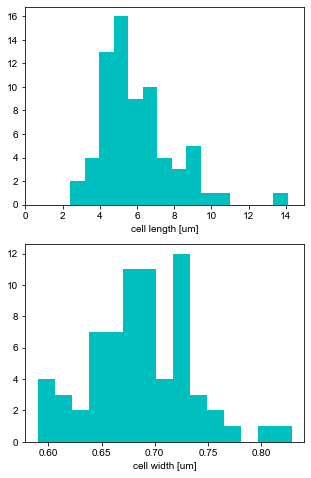

In [11]:
# Two simple graphs with the morphological data:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(5,8))

axes[0].hist(morph_df['length'], bins=15, fc='c')
axes[0].set_xlim(0,15)
axes[0].set_xlabel('cell length [um]')
axes[1].hist(morph_df['width_median'], bins=15, fc='c')
#axes[1].set_xlim(0.5,0.9)
axes[1].set_xlabel('cell width [um]')

# Step 5. Standard signal output format

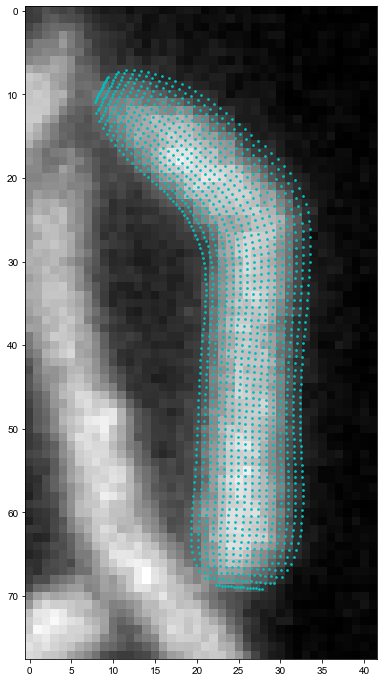

In [12]:
# demonstrate cellular profiling mesh

data = cell.data['C1']
profiling_mesh = cell.profile_mesh
fig=plt.figure(figsize=(12,12))
plt.imshow(data,cmap='gist_gray')
plt.scatter(profiling_mesh[1],profiling_mesh[0],c='c',s=3)

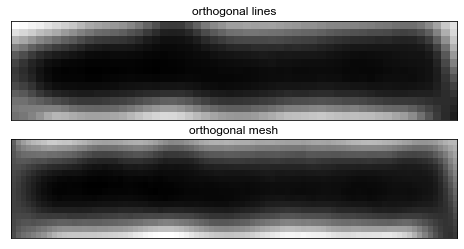

In [13]:
# demonstrate cellular profiling mesh

straighten = cell.measurements.signal_measurements['C2']['straighten']
straighten_mesh = np.flip(cell.measurements.signal_measurements['C2']['straighten_normalized'],axis=0)

fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,4))
axes[0].imshow(straighten, aspect='auto',cmap='gist_gray')
axes[0].set_title('orthogonal lines')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].imshow(straighten_mesh, aspect='auto',cmap='gist_gray')
axes[1].set_title('orthogonal mesh')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

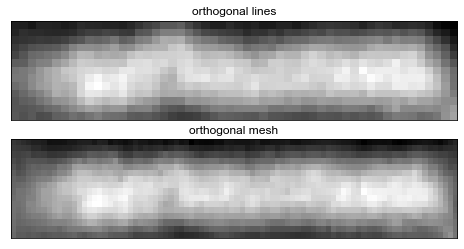

In [14]:
# demonstrate cellular profiling mesh

straighten = cell.measurements.signal_measurements['C1']['straighten']
straighten_mesh = np.flip(cell.measurements.signal_measurements['C1']['straighten_normalized'],axis=0)

fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,4))
axes[0].imshow(straighten, aspect='auto',cmap='gist_gray')
axes[0].set_title('orthogonal lines')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].imshow(straighten_mesh, aspect='auto',cmap='gist_gray')
axes[1].set_title('orthogonal mesh')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

In [15]:
wag31 = om.io.process_single_input(imagefile=data_folder+'wag31.tif',
                                   header='wag31',
                                   dest_folder=data_folder,
                                   save_input=False,
                                   save_segmentation_result=False,
                                   save_cells=False,
                                   return_obj=True)

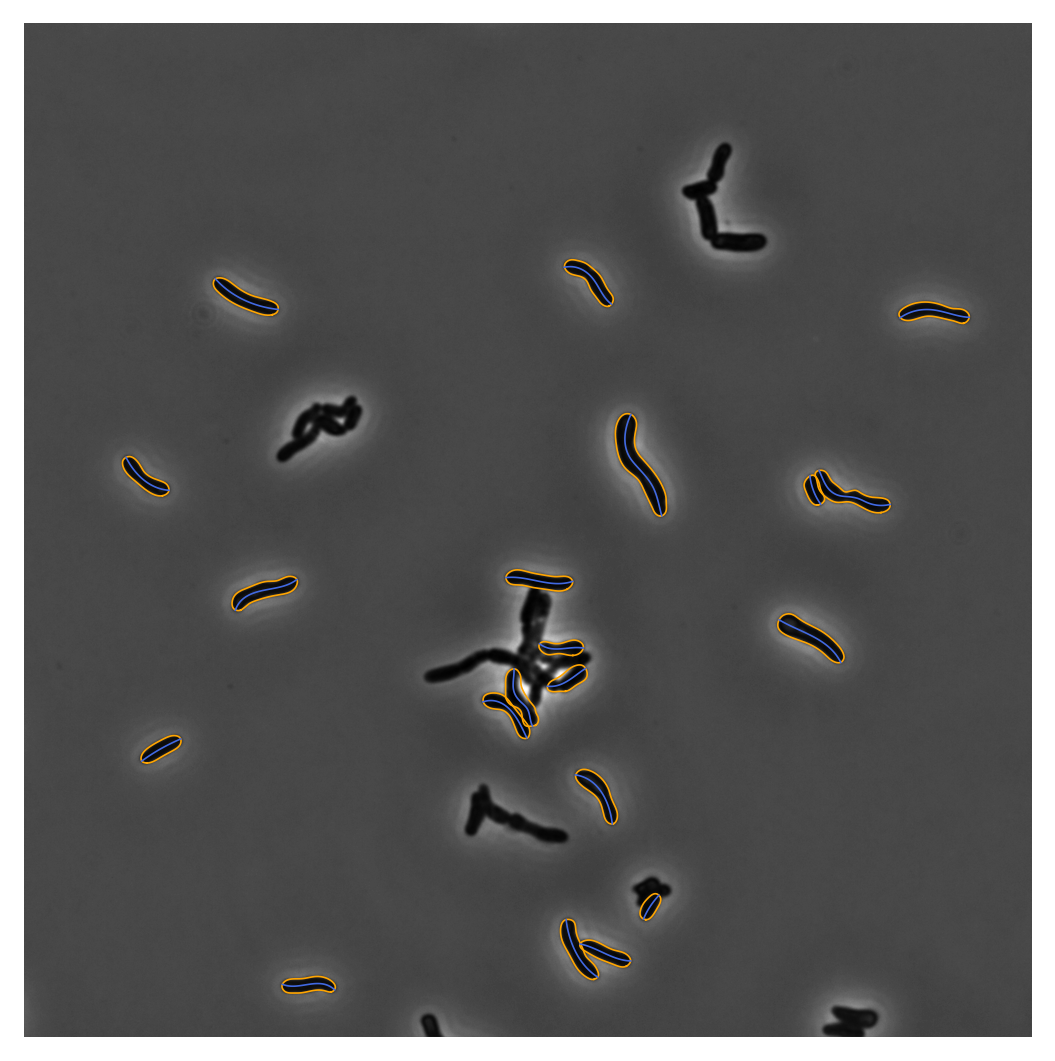

In [16]:
om.plot.plot_segmented_image(wag31,show_branched=False,show_discarded=False)

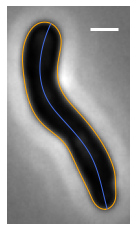

In [17]:
# cell visualization
wag31_cells = wag31.get_cells()
om.plot.plot_cell(wag31_cells[3],lw=1,scale_bar=True)

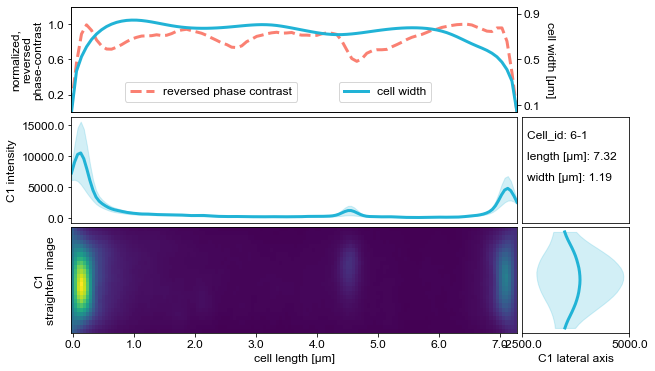

In [18]:
# We could also plot out the basic signal profiles of single cells
om.plot.cell_plot_full(wag31_cells[3])

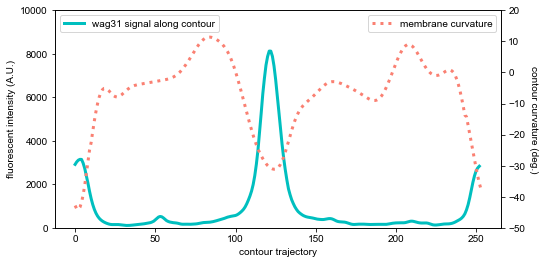

In [19]:
# correlation between membrane negtive curvature and wag31 signal intensity
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(om.helper.measure_along_contour(wag31_cells[3],'C1'),c='c',lw=3,
         label='wag31 signal along contour')
ax1.set_ylim(0,10000)
ax1.set_ylabel('fluorescent intensity (A.U.)')
ax1.set_xlabel('contour trajectory')
plt.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(-om.helper.bend_angle(wag31_cells[3].optimized_contour),c='salmon',lw=3,ls=':',
         label='membrane curvature')
ax2.set_ylim(-50,20)
ax2.set_ylabel('contour curvature (deg.)',rotation=270,va='bottom')
plt.legend()

In [20]:
mtb = om.io.process_single_input(imagefile=data_folder+'mtb_clinical_isolate_3.tif',
                                 configfile="./OMEGA_core/configurations/configuration_mtb.ini",
                                 header='mtb',
                                 dest_folder=data_folder,
                                 save_input=False,
                                 save_segmentation_result=False,
                                 save_cells=False,
                                 return_obj=True)

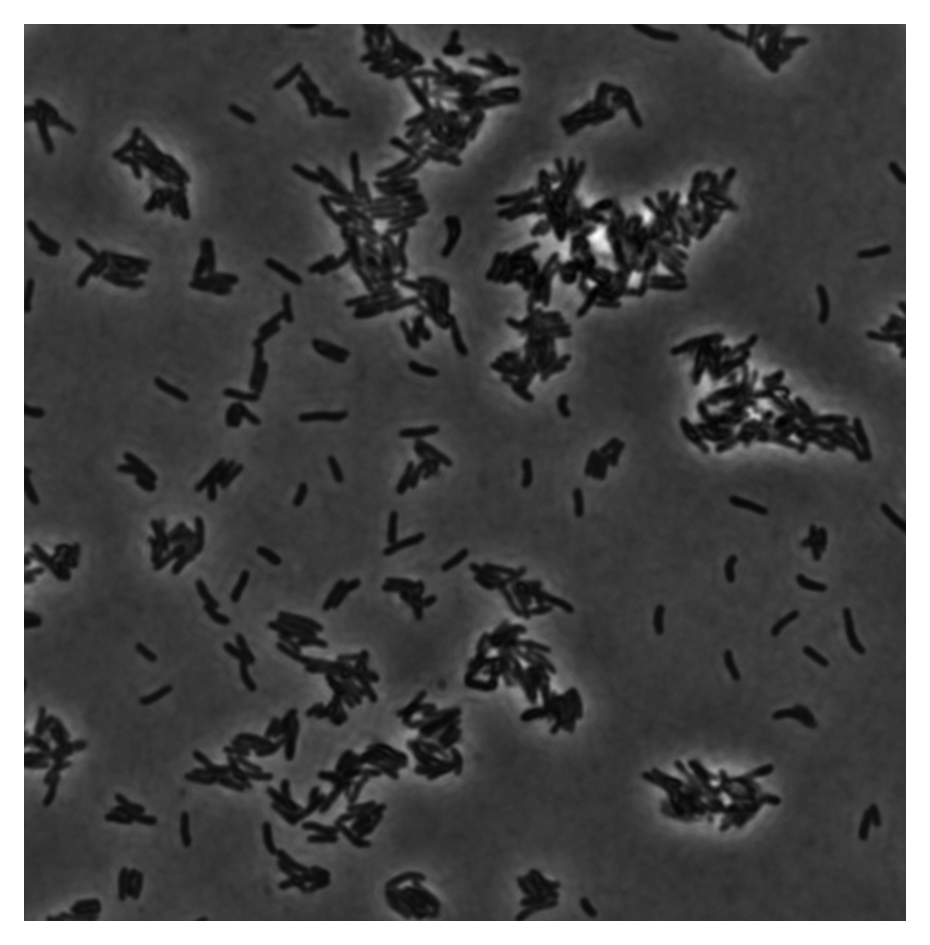

In [22]:
om.plot.plot_segmented_image(mtb,
                             show_accepted=False,
                             show_branched=False,
                             show_discarded=False,lw=0.5)

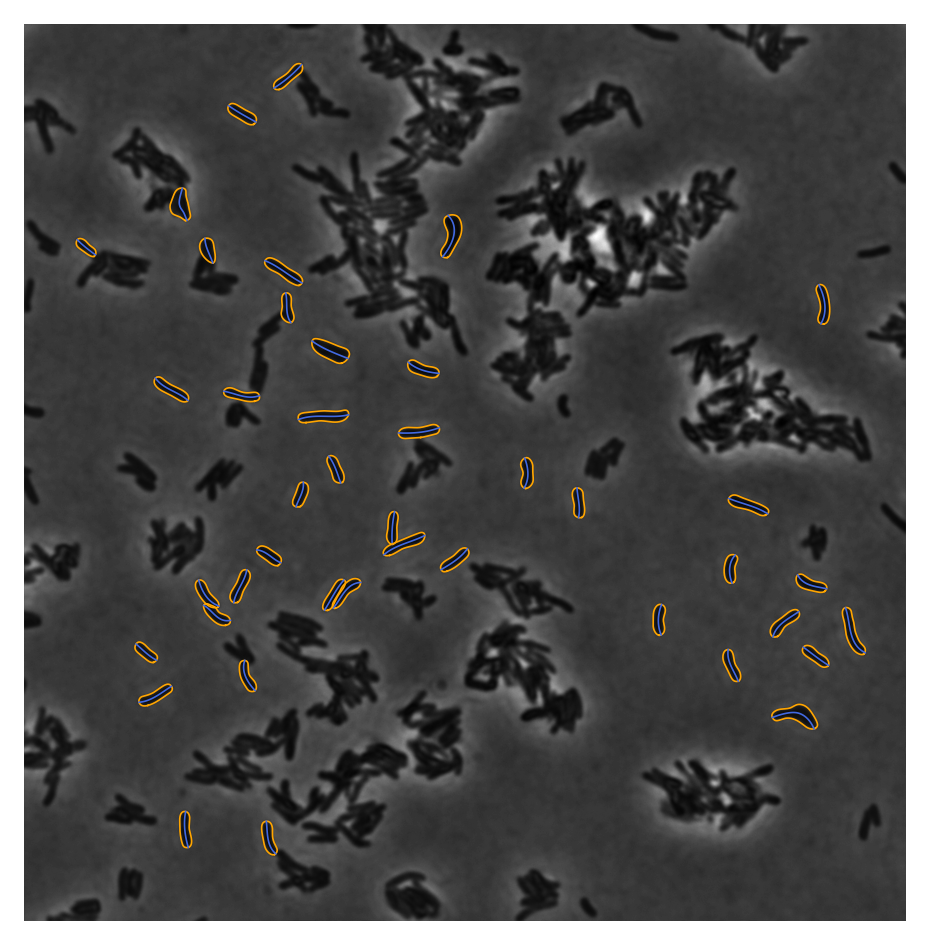

In [23]:
om.plot.plot_segmented_image(mtb,
                             show_accepted=True,
                             show_branched=False,
                             show_discarded=False,lw=0.5)

Text(0.5, 1.0, 'Phase contrast')

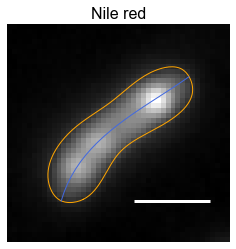

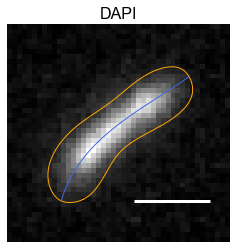

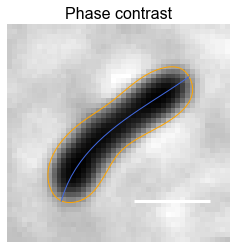

In [24]:
mtb_cells=mtb.get_cells()
ax1=om.plot.plot_cell(mtb_cells[33],lw=1,channel='C1',scale_bar=True,return_fig=True)
ax1.set_title('Nile red',fontsize=16)
ax2=om.plot.plot_cell(mtb_cells[33],lw=1,channel='C2',scale_bar=True,return_fig=True)
ax2.set_title('DAPI',fontsize=16)
ax3=om.plot.plot_cell(mtb_cells[33],lw=1,channel='C3',scale_bar=True,return_fig=True)
ax3.set_title('Phase contrast',fontsize=16)

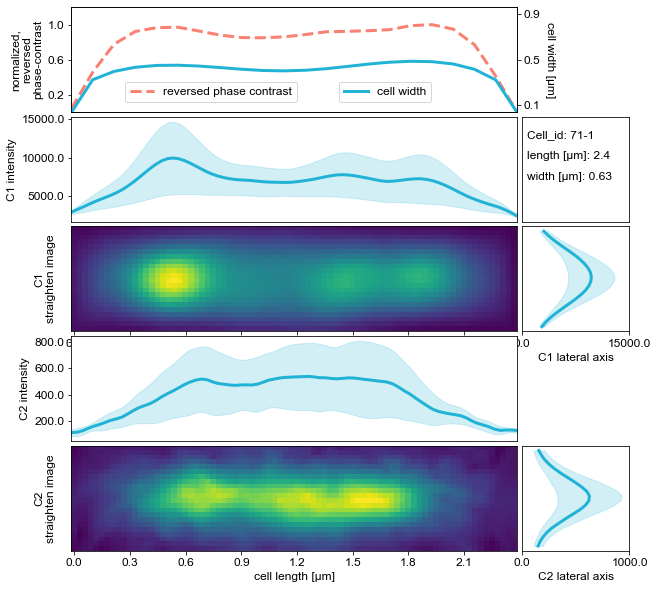

In [25]:
om.plot.cell_plot_full(mtb_cells[33])